<a id='Top'></a><br><br>
[Imports](#imports)<br> [Function List](#funclist)<br> [Apply band pass filter](#bpf)<br> [Create epochs using events](#epoching)<br> [Generate labels array from epochs](#labeling)<br>[Fit ICA to the epochs data](#ica)<br>[Apply ICA to the epochs data](#ica-apply)<br> [Apply standard scala](#sc)<br> [SVM](#svm)<br>[Model CNN](#createmodelCNN)<br>[Model CNN EEG-Conv-R](#createmodelCNN-R)<br>[Model RNN](#createmodelRNN)<br>[Model RNN convR](#createmodelRNNR)<br>[Confusion Matrix](#Confusionmarix)<br>[Define file paths](#filepaths)<br> [Load model saved in json file](#loadmodel)<br>[Fit the model](#fitmodel)<br>[Prediction](#prediction) 

<a id='imports'></a>
# Imports

In [1]:
import mne
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.decoding import Scaler

import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Add,Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D,Input,LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm 

import os.path 
from os import path
import pickle
import time

In [2]:
# class My_Custom_Generator(Model) :
  
#   def __init__(self, image_filenames, labels, batch_size) :
#     self.image_filenames = image_filenames
#     self.labels = labels
#     self.batch_size = batch_size
    
#   def __len__(self) :
#     return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
#   def __getitem__(self, idx) :
#     batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
#     batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
#     return np.array([
#             resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
#                for file_name in batch_x])/255.0, np.array(batch_y)


# class DataGenerator(Model):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=32, dim=(40,500), n_channels=1,
#                  n_classes=2, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = np.load('data/' + ID + '.npy')

#             # Store class
#             y[i] = self.labels[ID]

#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

<a id='funclist'></a>
# Function list
<a href=#Top>Top</a>

In [3]:
path_montage_home = r"F:\SAMEERA\M.Phill\EEG Data"
path_montage_work = r"D:\EEG"

path_list_montage = [path_montage_home, path_montage_work]

def loadfiles(path):
    import glob
    file_list = glob.glob(path)
    return file_list

    
def readcnt_noevent(cnt_file, event_id, duration):
    
    for montage_path in path_list_montage:
        if (path.exists(montage_path)):
            montage = mne.channels.read_montage('NuAmps40', path=montage_path)
    
    
    raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)

    # drop unwanted channels 
#     raw = raw.drop_channels(['HEOL', 'HEOR','VEOU','VEOL', 'FP2', 'F7', 'F3', 'F4',
#                             'FT7', 'FCZ', 'FT8', 'C3', 'C4', 'TP7', 'CPZ', 'TP8',
#                             'T5', 'PZ', 'T6', 'O1', 'O2', 'FT10', 'PO2'])

    raw = raw.drop_channels(['FP2', 'F3', 'F4', 'FT7', 'FCZ', 'FT8', 'C3', 'C4', 'TP7', 'CPZ', 'TP8',
                             'T5', 'PZ', 'T6', 'O1', 'O2', 'FT10', 'PO2'])

    raw = raw.drop_channels(['HEOR','VEOL'])  

    mne.io.set_bipolar_reference(raw, 'HEOL', 'VEOU', ch_name='EOG', copy=False)
    
    #raw.info['bads'] = ['F7', 'FZ', 'F8', 'FC4', 'A2']

     
    ###### add stimulus channel #########
    stim_data = np.zeros((1, len(raw.times)))
    info = mne.create_info(['STI'], raw.info['sfreq'], ['stim'])
    stim_raw = mne.io.RawArray(stim_data, info)
    raw.add_channels([stim_raw], force_update_info=True)

    raw.set_channel_types({'STI': 'stim'})
    
    ##### Setting fixed length events ########
    events = mne.make_fixed_length_events(raw, event_id , duration=duration)
    
    # Replacing the stim channel with events
    channel_index_no = len(raw.ch_names)-1

    for sample_index in events[:,0]:
        #print(sample_index)
        raw._data[channel_index_no, sample_index] = event_id
        
#     eog_channels = ['HEOL', 'HEOR','VEOU','VEOL']
    
#     eog_events = []
    
#     for eog_channel in eog_channels:
#         eog_events = mne.preprocessing.find_eog_events(raw, event_id, ch_name=eog_channel)
#         raw.add_events(eog_events, 'STI')
    
    return raw;

def raw_concat(raw1, raw2):
    # Concatenating raws
    from mne.io import  concatenate_raws
    if(raw1 == None):
        raw = raw2
    else:
        raws = [raw1, raw2]
        raw = concatenate_raws(raws)
    return raw;



# Save raw data into a single file
<a href=#Top>Top</a>

In [4]:
# training sample path for home laptop 
#path = training_data_path_home

# training sample path for campus workstation
#path = training_data_path_work 

def save_raw_data_single_file(folder_list):

    event_id = None
    raw = None

    for folder in folder_list:
        #print(folder)
        file_list = loadfiles(folder+"/*")
        for cnt_file in file_list:
            #print(cnt_file)
            #print("Loaded file %s" %cnt_file)
            duration= 5
            # raw.info

            if(os.path.basename(cnt_file) == r"Fatigue state.cnt"):
                event_id = 1

            if(os.path.basename(cnt_file) == r"Normal state.cnt"):
                event_id = 2

            # Read the file 1
            #edf_file = '/Volumes/STORAGE/Dropbox/RESEARCH in Sri Lanka/Experiments/Mandulee-digital poetry/data/1. Isuru/s/isuru-1s1-09.12.2015.03.48.12.edf';
            raw1 = readcnt_noevent(cnt_file, event_id, duration)

            # Concatenating files
            raw = raw_concat(raw, raw1)

    outfile = open(output_file_path + r'\raw_data','wb')
    pickle.dump(raw,outfile)
    outfile.close()

# Read raw data file
<a href=#Top>Top</a>

In [5]:
def read_raw_data_file(path):
    inputfile = open(path + r"\raw_data","rb")
    raw = pickle.load(inputfile)
    return raw

# # apply ICA
# ica = mne.preprocessing.ICA(random_state=97, max_iter=800)
# ica.fit(raw)
# raw.load_data()
# ica.apply(raw)
# ica.plot_properties(raw)

<a id='bpf'></a>
# Apply band pass filter
<a href=#Top>Top</a>

In [6]:
def band_pass_filter(raw):
    raw.filter(4., 40., fir_design='firwin')
    return raw

<a id='epoching'></a>
# Create epochs using events
<a href=#Top>Top</a>

In [7]:
def epoching(raw, event_ids):
    
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude=[])
    
    events = mne.find_events(raw, stim_channel='STI', shortest_event=1)
    
    print('raw: ', raw.ch_names)
    
    # define an epoch size
    tmin, tmax = -0.0, 0.499

    # reject epochs which have their values over 150 micro volts
    reject = None#dict(eeg=150e-6)

    # create epochs
    epochs = mne.Epochs(raw, events, event_id=event_ids, baseline=(0,0), tmin=tmin, tmax=tmax, 
                        preload=True, reject=reject, picks=picks)
    #evoked = epochs.average()
    print('epochs: ', epochs.ch_names)
    epochs.plot(title='original')
    
#     epochs_interpoted_bads = epochs.interpolate_bads(reset_bads=True, verbose=False)
    
#     epochs_interpoted_bads.plot()
    
    return epochs

<a id='labeling'></a>
# Generate labels array from epochs 
<a href=#Top>Top</a>

In [8]:
def labeling(epochs):
    # this list stores label of each epoch
    epochs_labels = []

    i = 0
    epochs_length = epochs.__len__()
    while i < epochs_length:
        full_label_id = epochs[i].event_id
        #print(full_label_id)
        if ('1' in full_label_id.keys()):
            epochs_labels.append(1)
        elif ('fatigue_state' in full_label_id.keys()) :
            epochs_labels.append(1)
        else:
            epochs_labels.append(0)
        i = i+1
     
    # label format suitable for the 'loss' function
    from tensorflow.keras.utils import to_categorical
    categoric_epochs_labels = to_categorical(epochs_labels, num_classes=2)
    
    print(categoric_epochs_labels[1], epochs_labels[1])
        
    return categoric_epochs_labels, epochs_labels

<a id='ica'></a>
# Fit ICA to the epochs data
<a href=#Top>Top</a>

In [9]:
def ica_preprocessing(epochs):
    %matplotlib
    
    picks_eeg = mne.pick_types(epochs.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
    
    #n_components = 25  # if float, select n_components by explained variance of PCA
    method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
    decim = 3  # we need sufficient statistics, not all time points -> saves time

    # we will also set state of the random number generator - ICA is a
    # non-deterministic algorithm, but we want to have the same decomposition
    # and the same order of components each time this tutorial is run
    random_state = 23
    
    reject = dict(eeg=200e-6)
    
    ica = ICA(method=method, random_state=random_state)
    
    ica.fit(epochs.drop_bad(reject=reject), decim=decim)
    

    
#     eog_average = create_eog_epochs(raw, ch_name='EOG').average()

#     eog_epochs = create_eog_epochs(raw, ch_name='EOG')  # get single EOG trials
#     eog_inds, scores = ica.find_bads_eog(eog_epochs, ch_name='EOG' )  # find via correlation

#     ica.plot_scores(scores, exclude=eog_inds)  # look at r scores of components
#     # we can see that only one component is highly correlated and that this
#     # component got detected by our correlation analysis (red).

#     ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course
    
#     ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
#                     image_args={'sigma': 1.})
    
#     print(ica.labels_)
    
#     ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
#     # red -> before, black -> after. Yes! We remove quite a lot!

#     # to definitely register this component as a bad one to be removed
#     # there is the ``ica.exclude`` attribute, a simple Python list
#     ica.exclude.extend(eog_inds)

#     # from now on the ICA will reject this component even if no exclude
#     # parameter is passed, and this information will be stored to disk
#     # on saving

    # uncomment this for reading and writing
    # ica.save('my-ica.fif')
    
    
#     raw_copy = raw.copy()
#     ica.apply(raw_copy)
#     raw_copy.plot()  # check the result
#     raw.plot()
    
    return epochs,ica

<a id='ica-apply'></a>
# Apply ICA
<a href=#Top>Top</a>

In [10]:
def apply_ica(ica_epochs):
    eog_average = ica_epochs.average()
    eog_inds, scores = ica.find_bads_eog(ica_epochs, ch_name='EOG' )  # find via correlation

    ica.plot_scores(scores, exclude=eog_inds)  # look at r scores of components
    # we can see that only one component is highly correlated and that this
    # component got detected by our correlation analysis (red).

    ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course

    if len(eog_inds) !=0 :
        ica.plot_properties(ica_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.})

    #print(ica.labels_)

    ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
    # red -> before, black -> after.

    # to definitely register this component as a bad one to be removed
    # there is the ``ica.exclude`` attribute, a simple Python list
    ica.exclude.extend(eog_inds)


<a id='sc'></a>
# Apply standard scalar
<a href=#Top>Top</a>

In [11]:
def z_score(epochs, labels=None):
    epochs_data = epochs.get_data()
    
    print(epochs_data.shape)
    
    h = epochs_data.shape[1]-1
    w = epochs_data.shape[2]

    # Remove EOG channel and reshape to fit the tensorflow input
    epochs_data = epochs_data [:, 1:,:]
    
    print(epochs_data.shape)
    
    scaler = Scaler(info=None, scalings='mean')
    epochs_scaled = scaler.fit_transform(epochs_data,labels)
    print(epochs_scaled.shape)
    
    epochs_scaled = epochs_scaled.reshape(-1,h,w,1)
    
#     h = epochs_scaled.shape[1]-1
#     w = epochs_scaled.shape[2]

# #     # Remove marker channel and reshape to fit the tensorflow input
#     epochs_scaled = epochs_scaled [:, :-1,:].reshape(-1,h,w,1)
    
    return epochs_scaled

<a id='svm'></a>
# SVM
<a href=#Top>Top</a>

In [12]:
# accept 2D array and labels

def SVM_Classify(feature_vectors_final, labels):
    #print(feature_vectors_final.shape)

    X_train, X_test, y_train, y_test = train_test_split(feature_vectors_final, labels, test_size=0.4, random_state=0);
#     print(X_train.shape, y_train.shape)
#     print(X_test.shape, y_test.shape)

    clf = svm.SVC(kernel='rbf', C=2).fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print("Accuracy is %f" %clf.score(X_test, y_test));
    return clf

<a id='createmodelCNN'></a>
# CNN model layout
<a href=#Top>Top</a>

In [13]:
def create_CNN_model(input_shape):

    # Always have to give a 4D array as input to the CNN
    visible = Input(input_shape[1:])

    conv1 = Conv2D(32, (5,5), activation='relu', strides=1, bias_initializer='zeros')(visible)
    # model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    lrn2 = tf.nn.local_response_normalization(conv1)

    conv3 = Conv2D(64, (3,3), strides=1, activation='relu', bias_initializer='zeros')(lrn2)
    # model.add(MaxPooling2D(pool_size=(2,2), padding='same',))

    conv4 = Conv2D(32, (3,3), activation='relu', strides=1, bias_initializer='zeros')(conv3)

    pool5 = MaxPooling2D(pool_size=(2,2), strides = 2)(conv4)

    #flat1 = Flatten()(pool5)
    dense1 = Dense(2048)(pool5)
    fc6 = Dropout(0.5)(dense1)
    flat1 = Flatten()(fc6)

    output = Dense(2, activation='softmax')(flat1)

    model = Model(inputs=visible, outputs=output)
    print(model.summary())
    plot_model(model, to_file=r'model_plot.png', show_shapes=True, show_layer_names=True)

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model


<a id='createmodelCNN-R'></a>
# CNN EEG-Conv-R model
<a href=#Top>Top</a>

In [14]:
def identity_block(X):

    # Save the input value. need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    
    
    X = Conv2D(32, (5,5), strides=1, activation='relu', bias_initializer='zeros', padding = 'same')(X)
    activation1 = Activation('relu')(X)
    
    #print(activation1.shape)
    
    # Second component of main path (≈3 lines)
    
    
    X = Conv2D(32, (3,3), strides=1, bias_initializer='zeros', padding = 'same')(X)
    #print(X.shape)
    
#     X_shortcut = Conv2D(32, (3,3), strides=1, bias_initializer='zeros')(X_shortcut)
#     print(X_shortcut.shape)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [15]:
def create_CNN_model_R(input_shape):

    # Always have to give a 4D array as input to the CNN
    visible = Input(input_shape[1:])

    X = Conv2D(32, (3,3), activation='relu', strides=3, bias_initializer='zeros', padding = 'same')(visible)
    #print(X.shape)
    
    X = identity_block(X)
    
    lrn = tf.nn.local_response_normalization(X)

    X = identity_block(lrn)

    #pool5 = MaxPooling2D(pool_size=(2,2), strides = 2)(conv4)

    dense = Dense(4096)(X)
    fc = Dropout(0.5)(dense)
    flat = Flatten()(fc)

    output = Dense(2, activation='softmax')(flat)

    model = Model(inputs=visible, outputs=output)
    #print(model.summary())
    plot_model(model, to_file=r'model_plot_R.png', show_shapes=True, show_layer_names=True)

    print(model.summary())
    
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

<a id='createmodelRNN'></a>
# RNN model layout
<a href=#Top>Top</a>

In [16]:
def create_RNN_model(input_shape):
    
    #model = Sequential()
    
    # The input to every LSTM layer must be three-dimensional.
    visible = Input(input_shape[1:-1])
    
    lstm1 = LSTM(512, return_sequences=True)(visible)
    
    lstm2 = LSTM(1024, return_sequences=True)(lstm1) 
    
    lstm3 = LSTM(2048, return_sequences=True)(lstm2)
    
    flat1 = Flatten()(lstm3)
    
    dense1 = Dense(512)(flat1)
    
    output = Dense(2, activation='softmax')(dense1)

    model = Model(inputs=visible, outputs=output)
    print(model.summary())
    plot_model(model, to_file=r'model_plot.png', show_shapes=True, show_layer_names=True)

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

<a id='createmodelRNNR'></a>
# RNN ConvR model layout
<a href=#Top>Top</a>

In [17]:
def identity_block_rnn(rnn_width,X):

    # Save the input value. need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = LSTM(rnn_width, return_sequences=True)(X)
    # padded_X = tf.keras.preprocessing.sequence.pad_sequences(X,padding='post')
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    
    
    return X

In [18]:
def create_RNN_model_R(input_shape):
    
    # The input to every LSTM layer must be three-dimensional.
    visible = Input(input_shape[1:-1])
    
    lstm1 = LSTM(512, return_sequences=True)(visible)
    
    X = identity_block_rnn(1024, lstm1) 
    
    X = identity_block_rnn(2048, X)
    
    flat1 = Flatten()(X)
    
    dense1 = Dense(512)(flat1)
    
    output = Dense(2, activation='softmax')(dense1)

    model = Model(inputs=visible, outputs=output)
    print(model.summary())
    plot_model(model, to_file=r'model_plot.png', show_shapes=True, show_layer_names=True)

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

<a id='Confusionmarix'></a>
### Confusion marix
<a href=#Top>Top</a>

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     weight='bold',
                     color="brown" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     weight='bold',
                     color="brown" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

<a id='filepaths'></a>
# Define file paths
<a href=#Top>Top</a>

In [20]:
data_path_work = r"D:\EEG\5202739"
data_path_home = r"F:\SAMEERA\M.Phill\EEG Data\5202739"

data_path_list = [data_path_work, data_path_home]

for data_path in data_path_list:
        if (path.exists(data_path)):
            training_folder_list = loadfiles(data_path + r"\Training\*")
            testing_folder_list = loadfiles(data_path + r"\Testing\*")
            output_file_path = data_path


In [22]:
#save_raw_data_single_file(training_folder_list)
training_raw_data = read_raw_data_file(output_file_path)
raw = band_pass_filter(training_raw_data)
event_ids = dict(fatigue_state=1, normal_state=2)
training_epochs = epoching(raw, event_ids)
#training_epochs.ch_names
ica_epochs, ica = ica_preprocessing(training_epochs)
apply_ica(ica_epochs)

epochs_copy = ica_epochs.copy()
ica.apply(ica_epochs)
# ica_epochs.plot(title='ica applied')  # check the result
# epochs_copy.plot(title='original')
# ica_epochs.plot_psd(fmax=50, average=True)

training_labels_categorical, training_labels = labeling(training_epochs)
# print(training_labels)
training_epochs.get_data().shape

standardized_epochs = z_score(ica_epochs, training_labels)
input_shape = standardized_epochs.shape
print("standardize epochs shape : ",standardized_epochs.shape)
print("input shape : ",input_shape[:-1])

Filtering raw data in 16 contiguous segments
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 sec)

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1919 events found
Event IDs: [1 2]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
1919 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projectio

    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3', 'A1', 'P4']
    Rejecting  epoch based on EEG : ['T4', 'CP3', 'P4']
    Rejecting  epoch based on EEG : ['CP3', 'A1', 'P4']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['FC4', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3', 'OZ']
    Rejecting  epoch based on EEG : ['T4', 'CP3', 'OZ']
    Rejecting  epoch based on EEG : ['EOG', 'CP3']
    Rejecting  epoch based on EEG : ['EOG', 'CP3']
    Rejecting  epoch based on EEG : ['CP3', 'CP4']
    Rejecting  epoch based on EEG : ['EOG', 'CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['EOG', 'F7', 'CP3']
    Rejecting  epoch based on EEG : ['F7', 'CP3', 'PO1']
    Rejecting  epoch based on E

    Rejecting  epoch based on EEG : ['EOG']
    Rejecting  epoch based on EEG : ['EOG']
    Rejecting  epoch based on EEG : ['EOG', 'CP3']
    Rejecting  epoch based on EEG : ['EOG', 'CP3']
    Rejecting  epoch based on EEG : ['EOG', 'T4', 'CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3', 'A1']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['FZ', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['FZ', 'CP3']
    Rejecting  epoch based on EEG : ['FZ', 'CP3']
    Rejecting  epoch based on EEG : ['FZ', 'CP3']
    Rejecting  epoch based on EEG : ['FZ', 'CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['FC4', 'CP3']
    Rejecting  epoch based on EEG : ['FC4', 'CP3']
    Rejecting

    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['EOG', 'FC3']
    Rejecting  epoch based on EEG : ['EOG']
    Rejecting  epoch based on EEG : ['EOG']
    Rejecting  epoch based on EEG : ['EOG', 'F8', 'FC3']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['EOG']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['EOG', 'FP1', 'F7', 'F8', 'FC3',

    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['T3', 'CP3']
    Rejecting  epoch based on EEG : ['T3', 'CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['T4', 'CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['EOG', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['EOG', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['EOG', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['CP3', 'A1']
    Rejecting  epoch based on EEG : ['EOG', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['EOG', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['EOG', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['EOG', 'CP3', 'A1']
    Rejecting  epoch based on EEG : ['EOG', 'CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  e

    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['T3', 'CP3']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['EOG']
    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
    Rejecting  epoch based on EEG : ['CP3', 'FT9']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CZ', 'CP3']
    Rejecting  epoch based on EEG : ['CZ']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CZ', 'CP3', 'P4']
    Rejecting  epoch based on EEG : ['CZ', 'P4']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['CP3', 'P4', 'FT9']
    Rejecti

<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [6] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


    Using multitaper spectrum estimation with 7 DPSS windows
680 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Transforming to ICA space (19 components)
Zeroing out 1 ICA components
Transforming to ICA space (19 components)
Zeroing out 1 ICA components
[0. 1.] 1
(680, 19, 500)
(680, 18, 500)
(680, 18, 500)
standardize epochs shape :  (680, 18, 500, 1)
input shape :  (680, 18, 500)


In [22]:
from math import modf

std_shape = standardized_epochs.shape

print(standardized_epochs.reshape(std_shape[0], std_shape[1], std_shape[2]).shape)
list1 = np.asarray(standardized_epochs[:,:,:,0]) 
training_array = []
validation_array = []
i = 0
j = modf(std_shape[0]*2/3)[1]
if i < j:
    while i < j:
        training_array.append(list1[i,:,:])
        i = i+1
if i >= j:
    while i < std_shape[0]:
        validation_array.append(list1[i,:,:])
        i = i+1
        
training_array = np.asarray(training_array)
validation_array = np.asarray(validation_array)
print(training_array.shape)
print(validation_array.shape)


    

(680, 18, 500)
(453, 18, 500)
(227, 18, 500)


In [23]:
keys = ['train', 'validation']
values = [training_array, validation_array]
predintion_dictionary = dict(zip(keys, values))
print(predintion_dictionary['validation'].shape)

(227, 18, 500)


<a id=#fitmodel></a>
# Fit the model
<a href=#Top>Top</a>

[Call backs](#cb)<br>[cnn fit](#cnnfit)<br>[cnn convR fit](#cnnRfit)<br>[rnn fit](#rnnfit)<br>[rnn convR fit](#rnnRfit)<br>

### SVM model fit

In [ ]:
# reshape the standardized data into 2d

# windows, channels, samples = standardized_epochs[:,:,:,0].shape
# feature_vectors_final = standardized_epochs.reshape((windows, channels*samples))

feature_vectors_final = standardized_epochs.reshape(len(standardized_epochs[:,:,:,0]),-1)
print("feature vector final", feature_vectors_final.shape)
print(np.asarray(training_labels).shape)
model = SVM_Classify(feature_vectors_final, training_labels)

In [ ]:
from sklearn.model_selection import validation_curve
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    svm.SVC(kernel='rbf', C=2), feature_vectors_final, training_labels, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

<a id="cb"></a>
#### Callbacks
<a href=#Top>Top</a>

In [29]:
# modelcheckpoint
checkpoint_prefix_cnn = "F:\SAMEERA\M.Phill\modelcheckpoint\CNN_checkpoint\model_CNN_{epoch}"
checkpoint_prefix_cnn_convR = "F:\SAMEERA\M.Phill\modelcheckpoint\CNN_convR_checkpoint\model_CNN_convR_{epoch}"

checkpoint_prefix_rnn = "F:\SAMEERA\M.Phill\modelcheckpoint\RNN_checkpoint\model_RNN_{epoch}"
checkpoint_prefix_rnn_convR = "F:\SAMEERA\M.Phill\modelcheckpoint\RNN_convR_checkpoint\model_RNN_convR_{epoch}"

# SAVE the weights for the model in the epoch with the lowest val_loss
checkpoint_callback_cnn = ModelCheckpoint(filepath=checkpoint_prefix_cnn, save_best_only=True, 
                                     save_weights_only=True, monitor='val_accuracy', verbose=2)

checkpoint_callback_cnn_convR = ModelCheckpoint(filepath=checkpoint_prefix_cnn_convR, save_best_only=True, 
                                     save_weights_only=True, monitor='val_accuracy', verbose=2)

checkpoint_callback_rnn = ModelCheckpoint(filepath=checkpoint_prefix_rnn, save_best_only=True, 
                                     save_weights_only=True, monitor='val_accuracy', verbose=2)

checkpoint_callback_rnn_convR = ModelCheckpoint(filepath=checkpoint_prefix_rnn_convR, save_best_only=True, 
                                     save_weights_only=True, monitor='val_accuracy', verbose=2)

# tensorboard
local_time = time.localtime(time.time())
logs_folder = "%s-%s" % (local_time.tm_mon,local_time.tm_mday)
time_format = "%s.%s" % (local_time.tm_hour,local_time.tm_min)

NAME_CNN = r"F:\SAMEERA\M.Phill\logs\%s\logs_cnn_%s" % (logs_folder,time_format)
tensorboard_cnn = TensorBoard(log_dir=NAME_CNN)

NAME_CNN_convR = r"F:\SAMEERA\M.Phill\logs\%s\logs_cnn_convR_%s" % (logs_folder,time_format)
tensorboard_cnn_convR = TensorBoard(log_dir=NAME_CNN_convR)

NAME_RNN =  r"F:\SAMEERA\M.Phill\logs\%s\logs_rnn_%s" % (logs_folder,time_format)
tensorboard_rnn = TensorBoard(log_dir=NAME_RNN)

NAME_RNN_convR =  r"F:\SAMEERA\M.Phill\logs\%s\logs_rnn_convR_%s" % (logs_folder,time_format)
tensorboard_rnn_convR = TensorBoard(log_dir=NAME_RNN_convR)

# callbacks array
callbacks_cnn = [checkpoint_callback_cnn, tensorboard_cnn]

callbacks_cnn_convR = [checkpoint_callback_cnn_convR, tensorboard_cnn_convR]

callbacks_rnn = [checkpoint_callback_rnn, tensorboard_rnn]

callbacks_rnn_convR = [checkpoint_callback_rnn_convR, tensorboard_rnn_convR]

In [25]:
# seperate traning and testing data

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(standardized_epochs, training_labels_categorical, test_size=0.33)

<a id="cnnfit"></a>
### CNN model fit
<a href=#Top>Top</a><br>
<a href=#cb>Call backs</a>

In [26]:
history_cnn = create_CNN_model(input_shape).fit(X_train,Y_train, batch_size=10, epochs=30, validation_split=0.1,
                    callbacks=callbacks_cnn)



# model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 500, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 496, 32)       832       
_________________________________________________________________
tf_op_layer_LRN (TensorFlowO [(None, 14, 496, 32)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 494, 64)       18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 492, 32)       18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 246, 32)        0         
_________________________________________________________________
dense (Dense)                (None, 5, 246, 2048)      67584 

Epoch 23/30
400/409 [============================>.] - ETA: 0s - loss: 5.0765e-05 - accuracy: 1.0000
Epoch 00023: val_accuracy did not improve from 0.89130
409/409 [==============================] - 20s 50ms/sample - loss: 5.1695e-05 - accuracy: 1.0000 - val_loss: 1.6680 - val_accuracy: 0.8043
Epoch 24/30
400/409 [============================>.] - ETA: 0s - loss: 5.1703e-05 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.89130
409/409 [==============================] - 20s 49ms/sample - loss: 5.0566e-05 - accuracy: 1.0000 - val_loss: 1.6635 - val_accuracy: 0.8043
Epoch 25/30
400/409 [============================>.] - ETA: 0s - loss: 3.7542e-05 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.89130
409/409 [==============================] - 20s 49ms/sample - loss: 3.8460e-05 - accuracy: 1.0000 - val_loss: 1.6637 - val_accuracy: 0.8043
Epoch 26/30
400/409 [============================>.] - ETA: 0s - loss: 3.5279e-05 - accuracy: 1.0000
Epoch 00026: v

In [26]:
model = create_CNN_model(input_shape)
latest_model = tf.train.latest_checkpoint(r'F:\SAMEERA\M.Phill\modelcheckpoint\CNN_checkpoint')
print(latest_model)
model.load_weights(latest_model)

score = model.evaluate(X_test, Y_test, verbose=1)
print('test loss, test acc:', score)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 500, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 496, 32)       832       
_________________________________________________________________
tf_op_layer_LRN (TensorFlowO [(None, 14, 496, 32)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 494, 64)       18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 492, 32)       18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 246, 32)        0         
_________________________________________________________________
dense (Dense)                (None, 5, 246, 2048)      67584 

<a id="cnnRfit"></a>
### CNN_convR model fit
<a href=#Top>Top</a><br>
<a href=#cb>Call backs</a>

In [27]:
print(input_shape)

history_cnn_convR =  create_CNN_model_R(input_shape).fit(X_train,Y_train, batch_size=10, epochs=30, validation_split=0.1,
                    callbacks=callbacks_cnn_convR)

(680, 18, 500, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 18, 500, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 6, 167, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 6, 167, 32)   25632       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 6, 167, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________

In [26]:
model = create_CNN_model_R(input_shape)
latest_model = tf.train.latest_checkpoint(r'F:\SAMEERA\M.Phill\modelcheckpoint\CNN_convR_checkpoInt')
print(latest_model)
model.load_weights(latest_model)

score = model.evaluate(X_test, Y_test, verbose=1)
print('test loss, test acc:', score)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 18, 500, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 6, 167, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 6, 167, 32)   25632       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 6, 167, 32)   9248        conv2d_6[0][0]                   
____________________________________________________________________________________________

<a id=rnnfit></a>
### RNN model fit
<a href=#Top>Top</a><br>
<a href=#cb>Call backs</a>

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(np.squeeze(standardized_epochs, axis=3), training_labels_categorical, test_size=0.33)

In [ ]:
history_rnn = create_RNN_model(input_shape).fit(X_train,Y_train, batch_size=10, epochs=30, validation_split=0.1,
                    callbacks=callbacks_rnn)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 18, 500)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 18, 512)           2074624   
_________________________________________________________________
lstm_4 (LSTM)                (None, 18, 1024)          6295552   
_________________________________________________________________
lstm_5 (LSTM)                (None, 18, 2048)          25174016  
_________________________________________________________________
flatten_3 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               18874880  
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026

In [46]:
model = create_RNN_model(input_shape)
latest_model = tf.train.latest_checkpoint(r'F:\SAMEERA\M.Phill\modelcheckpoint\RNN_checkpoInt')
print(latest_model)
model.load_weights(latest_model)

score = model.evaluate(X_test, Y_test, verbose=1)
print('test loss, test acc:', score)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 500)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 512)           2074624   
_________________________________________________________________
lstm_1 (LSTM)                (None, 18, 1024)          6295552   
_________________________________________________________________
lstm_2 (LSTM)                (None, 18, 2048)          25174016  
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               18874880  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026  

<a id=rnnRfit></a>
### RNN convR model fit
<a href=#Top>Top</a><br>
<a href=#cb>Call backs</a>

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(np.squeeze(standardized_epochs, axis=3), training_labels_categorical, test_size=0.33)

history_rnn = create_RNN_model_R(input_shape).fit(X_train,Y_train, batch_size=20, epochs=20, validation_split=0.1,
                    callbacks=callbacks_rnn)

## Evaluate model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18, 500)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 18, 512)           2074624   
_________________________________________________________________
lstm_4 (LSTM)                (None, 18, 1024)          6295552   
_________________________________________________________________
lstm_5 (LSTM)                (None, 18, 2048)          25174016  
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               18874880  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026

AttributeError: 'NoneType' object has no attribute 'endswith'

In [ ]:
print(tf.train.latest_checkpoint('F:\SAMEERA\M.Phill\modelcheckpoint'))

# Save model to jason
<a href=#Top>Top</a>

In [ ]:
def save_model(model,model_path, weight_path):
    # serialize model to JSON
    model_CNN = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_CNN)
    # serialize weights to HDF5
    model.save_weights(weight_path)
    print("Saved model to disk")

In [ ]:
model_path = r"F:\SAMEERA\M.Phill\EEG Data\5202739\model_CNN.json"
weight_path = r"F:\SAMEERA\M.Phill\EEG Data\5202739\model_weights.h5"
save_model(model, model_path, weight_path)

<a id='loadmodel'></a>
# Load model saved in json file
<a href=#Top>Top</a>

In [ ]:
def load_saved_model(model_path, weight_path):
    # load json and create model
    from tensorflow.keras.models import model_from_json
    json_file = open(model_pathr, 'r')
    loaded_model_CNN = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_CNN)
    # load weights into new model
    loaded_model.load_weights(weight_pathr)
    print("Loaded model from disk")
    
    return loaded_model

<a id='prediction'> </a>
# Predictions 
<a href=#Top>Top</a>

[cnn predict](#cnnpredict)<br>[cnn_convR predict](#cnnRpredict)<br>[rnn predict](#rnnpredict)<br>[svm predict](#svmpredict)<br>

Run the cells below before <br>
[Imports](#imports)<br> [Function List](#funclist)<br> [Apply band pass filter](#bpf)<br> [Create epochs using events](#epoching)<br> [Generate labels array from epochs](#labeling)<br>[Fit ICA to the epochs data](#ica)<br>[Apply ICA to the epochs data](#ica-apply)<br> [Apply standard scala](#sc)<br> [Define file paths](#filepaths)<br> [Load model saved in json file](#loadmodel) 

F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\10\Fatigue state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning: Could not 

Bipolar channel added as "EOG".
Creating RawArray with float64 data, n_channels=1, n_times=600240
    Range : 0 ... 600239 =      0.000 ...   600.239 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [1]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']


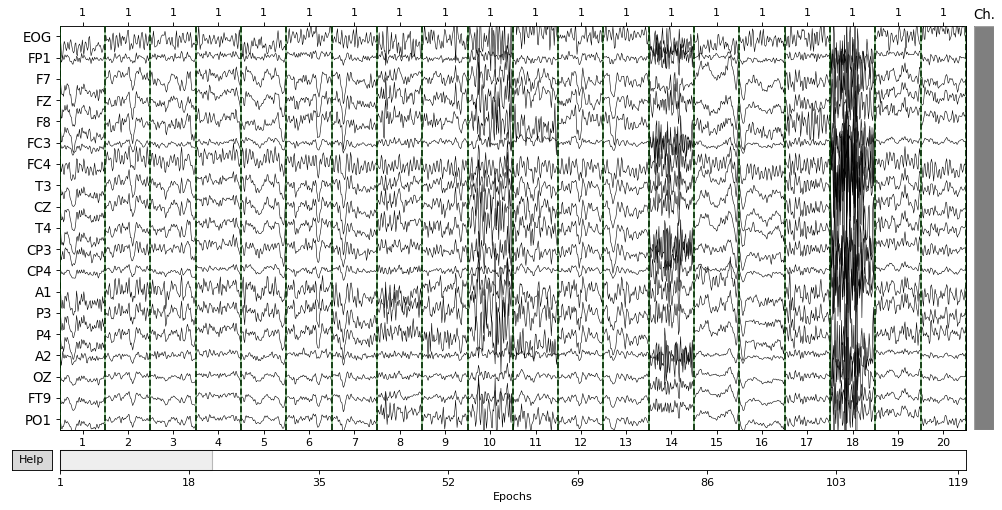

Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['FC4', 'CP4']
    Rejecting  epoch based on EEG : ['EOG', 'F7', 'FC3', 'FC4', 'CZ', 'T4', 'CP4', 'P3']
2 bad epochs dropped
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 19
Fitting ICA took 0.8s.
Using channel EOG as EOG channel
Transforming to ICA space (19 components)
Zeroing out 0 ICA components


<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


[0. 1.] 1
(117, 19, 500)
(117, 18, 500)
(117, 18, 500)
testing data shape  (117, 18, 500, 1)
(117,)
F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\10\Normal state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning: Could not 

Bipolar channel added as "EOG".
Creating RawArray with float64 data, n_channels=1, n_times=600480
    Range : 0 ... 600479 =      0.000 ...   600.479 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 2 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [2]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
Dropped 0 epochs
Channels marked as bad: []
Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['FZ']
    Rejecting  epoch based on EEG : ['FZ', 'T3']
    Rejecting  epoch based on EEG : ['FZ', 'T3']
    Rejecting  epoch based on EEG : ['FZ', 'T3']
    Rejecting  epoch based on EEG : ['FZ', 'T3']
    Rejecting  epoch b

F:\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


Transforming to ICA space (19 components)
Zeroing out 0 ICA components
[1. 0.] 0
(67, 19, 500)
(67, 18, 500)
(67, 18, 500)
testing data shape  (184, 18, 500, 1)
(184,)
F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\11\Fatigue state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
F:\Anaconda3\lib\site-packages\mne\io\cnt\cnt.py:247: Runtime

Bipolar channel added as "EOG".
Creating RawArray with float64 data, n_channels=1, n_times=601760
    Range : 0 ... 601759 =      0.000 ...   601.759 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [1]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
Dropped 0 epochs
Channels marked as bad: []
Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['CP3']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FC4

<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


Transforming to ICA space (19 components)
Zeroing out 0 ICA components
[0. 1.] 1
(31, 19, 500)
(31, 18, 500)
(31, 18, 500)
testing data shape  (215, 18, 500, 1)
(215,)
F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\11\Normal state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
F:\Anaconda3\lib\site-packages\mne\io\cnt\cnt.py:247: Runtime

Bipolar channel added as "EOG".
Creating RawArray with float64 data, n_channels=1, n_times=601040
    Range : 0 ... 601039 =      0.000 ...   601.039 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 2 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [2]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
Dropped 0 epochs
Channels marked as bad: []
Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['F7', 'FC4', 'CZ']
    Rejecting  epoch based on EEG : ['CZ']
    Rejecting  epoch based on EEG : ['F7', 'CZ']
    Rejecting  epoch based on EEG : ['F7', 'CZ']
    Rejecting  epoch based on EEG : ['CZ']
    Rejecting  epoch 

<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


[1. 0.] 0
(38, 19, 500)
(38, 18, 500)
(38, 18, 500)
testing data shape  (253, 18, 500, 1)
(253,)
F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\12\Fatigue state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning: Could not 

Bipolar channel added as "EOG".


<ipython-input-3-f1a87bf3fb5c>:19: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_dig_polhemus_isotrak``, or ``read_dig_captrack`` ``read_dig_hpts``, ``read_dig_captrack`` or ``read_custom_montage`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['HEOL', 'HEOR', 'VEOU', 'VEOL']. Their position has been left untouched.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: DeprecationWarning: The `montage` parameter from `read_raw_cnt` is deprecated and will 

Creating RawArray with float64 data, n_channels=1, n_times=602720
    Range : 0 ... 602719 =      0.000 ...   602.719 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [1]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
Dropped 0 epochs
Channels marked as bad: []
Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
   

<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


Transforming to ICA space (19 components)
Zeroing out 0 ICA components
[0. 1.] 1
(87, 19, 500)
(87, 18, 500)
(87, 18, 500)
testing data shape  (340, 18, 500, 1)
(340,)
F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\12\Normal state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
F:\Anaconda3\lib\site-packages\mne\io\cnt\cnt.py:247: Runtime

Bipolar channel added as "EOG".


<ipython-input-3-f1a87bf3fb5c>:19: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_dig_polhemus_isotrak``, or ``read_dig_captrack`` ``read_dig_hpts``, ``read_dig_captrack`` or ``read_custom_montage`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['HEOL', 'HEOR', 'VEOU', 'VEOL']. Their position has been left untouched.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: DeprecationWarning: The `montage` parameter from `read_raw_cnt` is deprecated and will 

Creating RawArray with float64 data, n_channels=1, n_times=600480
    Range : 0 ... 600479 =      0.000 ...   600.479 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 2 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [2]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
Dropped 0 epochs
Channels marked as bad: []
Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['CZ']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
   

<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [0] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


    Using multitaper spectrum estimation with 7 DPSS windows
93 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Transforming to ICA space (19 components)
Zeroing out 1 ICA components
[1. 0.] 0
(93, 19, 500)
(93, 18, 500)
(93, 18, 500)
testing data shape  (433, 18, 500, 1)
(433,)
F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\9\Fatigue state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
F:\Anaconda3\lib\site-packages\mne\io\cnt\cnt.py:247: Runtime

Bipolar channel added as "EOG".


<ipython-input-3-f1a87bf3fb5c>:19: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_dig_polhemus_isotrak``, or ``read_dig_captrack`` ``read_dig_hpts``, ``read_dig_captrack`` or ``read_custom_montage`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['HEOL', 'HEOR', 'VEOU', 'VEOL']. Their position has been left untouched.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: DeprecationWarning: The `montage` parameter from `read_raw_cnt` is deprecated and will 

Creating RawArray with float64 data, n_channels=1, n_times=602400
    Range : 0 ... 602399 =      0.000 ...   602.399 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [1]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
Dropped 0 epochs
Channels marked as bad: []
Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['CZ']
    Rejecting  epoch based on EEG : ['CZ']
   

<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [0] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


    Using multitaper spectrum estimation with 7 DPSS windows
66 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Transforming to ICA space (19 components)
Zeroing out 1 ICA components
[0. 1.] 1
(66, 19, 500)
(66, 18, 500)
(66, 18, 500)
testing data shape  (499, 18, 500, 1)
(499,)
F:\SAMEERA\M.Phill\EEG Data\5202739\Testing\9\Normal state.cnt


F:\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
F:\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, montage, preload=True, verbose=0)
<ipython-input-3-f1a87bf3fb5c>:19: RuntimeWarning: Could not 

Bipolar channel added as "EOG".
Creating RawArray with float64 data, n_channels=1, n_times=601520
    Range : 0 ... 601519 =      0.000 ...   601.519 secs
Ready.


<ipython-input-3-f1a87bf3fb5c>:42: RuntimeWarning: The unit for channel(s) STI has changed from V to NA.
  raw.set_channel_types({'STI': 'stim'})


Trigger channel has a non-zero initial value of 2 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found
Event IDs: [2]
raw:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1', 'STI']
119 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 119 events and 500 original time points ...
0 bad epochs dropped
epochs:  ['EOG', 'FP1', 'F7', 'FZ', 'F8', 'FC3', 'FC4', 'T3', 'CZ', 'T4', 'CP3', 'CP4', 'A1', 'P3', 'P4', 'A2', 'OZ', 'FT9', 'PO1']
Dropped 0 epochs
Channels marked as bad: []
Using matplotlib backend: Qt5Agg
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['T4', 'P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['EOG', 'P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG

<ipython-input-10-0298dc868f99>:9: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [0] will be ignored; falling back to ICA.exclude
  ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course


    Using multitaper spectrum estimation with 7 DPSS windows
82 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Transforming to ICA space (19 components)
Zeroing out 1 ICA components
[1. 0.] 0
(82, 19, 500)
(82, 18, 500)
(82, 18, 500)
testing data shape  (581, 18, 500, 1)
(581,)


In [21]:
event_id = None
raw = None
data_file_list = []
testing_label_list = []
pred_class = []

for folder in testing_folder_list:
   
    file_list = loadfiles(folder+"/*")
    for cnt_file in file_list:
        duration= 5

        print(os.path.abspath(cnt_file))
        
        if(os.path.basename(cnt_file) == r"Fatigue state.cnt"):
            event_id = 1

        if(os.path.basename(cnt_file) == r"Normal state.cnt"):
            event_id = 2
        
        # Read the file
        test_raw = readcnt_noevent(cnt_file, event_id, duration)
        
        bp_raw = band_pass_filter(test_raw)
        
        testing_epochs = epoching(bp_raw, event_id)
        
        #print(event_id,testing_labels)
        
        ica_testing_epochs, ica = ica_preprocessing(testing_epochs)
        
        apply_ica(ica_testing_epochs)
        
        testing_labels_binary, testing_labels = labeling(ica_testing_epochs)
        
        #print(testing_labels)
        
        standardized_testing_epochs = z_score(ica_testing_epochs)
        
        if(len(data_file_list) == 0 and len(testing_label_list) == 0):
            data_file_list = standardized_testing_epochs
            testing_label_list = testing_labels
        else:
            data_file_list = np.append(data_file_list, standardized_testing_epochs ,axis=0)
            testing_label_list = np.append(testing_labels,testing_label_list)
            
        print("testing data shape " , data_file_list.shape)
        print(np.asarray(testing_label_list).shape)

# Create a new model instance
input_shape = standardized_testing_epochs.shape


#  score = model.evaluate(standardized_testing_epochs, testing_labels_binary, verbose=1)
#  print("Accuracy: ", score[1])

#         # calculate the accuracy 
#         k = 0
#         i = 0
#         if(prediction.shape[0] != np.asarray(testing_labels).shape[0]):
#             print("predicted set size is diffrent from testing labels size")
#         else:
#             while(i<prediction.shape[0]):
#                 if(prediction[i]==testing_labels[i]):
#                     k = k+1
#                 i = i+1
            
                
#         print(k, np.asarray(testing_labels).shape[0])                  
#         accuracy = k/np.asarray(testing_labels).shape[0]
                          
#         print("Prediction accuracy = ",accuracy)        

<a id="cnnpredict"></a>
### CNN predict
<a href=#Top>Top</a>

In [ ]:
#-------------------  CNN  ---------------------#    

model = create_CNN_model(input_shape)
# load the latest model saved by model checkpoint with lowest val_loss
latest_model = tf.train.latest_checkpoint(r'F:\SAMEERA\M.Phill\modelcheckpoint\CNN_checkpoInt')

predict_input = data_file_list

<a id="cnnRpredict"></a>
### CNN convR predict
<a href=#Top>Top</a>

In [ ]:
#-------------------  CNN-convR  ---------------------#    

model = create_CNN_model_R(input_shape)
# load the latest model saved by model checkpoint with lowest val_loss
latest_model = tf.train.latest_checkpoint(r'F:\SAMEERA\M.Phill\modelcheckpoint\CNN_convR_checkpoInt')

predict_input = data_file_list 

<a id="rnnpredict"></a>
### RNN predict
<a href=#Top>Top</a>

In [22]:
#-------------------  RNN  ---------------------#

model = create_RNN_model(input_shape)
latest_model = tf.train.latest_checkpoint(r'F:\SAMEERA\M.Phill\modelcheckpoint\RNN_checkpoInt')

predict_input = data_file_list[:,:,:,0]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 500)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 512)           2074624   
_________________________________________________________________
lstm_1 (LSTM)                (None, 18, 1024)          6295552   
_________________________________________________________________
lstm_2 (LSTM)                (None, 18, 2048)          25174016  
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               18874880  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026  

### Predicted class list from CNN and RNN

In [23]:
print(latest_model)
model.load_weights(latest_model)

# get the predicted class labesl
if(len(pred_class) == 0):
    pred_class = model.predict(predict_input).argmax(axis=-1)
else:
    pred_class = np.append(pred_class,model.predict(predict_input).argmax(axis=-1))

F:\SAMEERA\M.Phill\modelcheckpoint\RNN_checkpoInt\model_RNN_8


<a id="svmpredict"></a>
### SVM predict
<a href=#Top>Top</a>

In [ ]:
predict_data = data_file_list.reshape(len(data_file_list[:,:,:,0]),-1)

pred_class = model.predict(predict_data)

In [24]:
print(np.array(testing_label_list).shape, np.array(pred_class).shape)
cm=confusion_matrix(testing_label_list,pred_class,labels=[0, 1])
print(cm)
plot_confusion_matrix(cm=cm, 
              normalize    = False,
              target_names = ['Normal','Fatigue'],
              title        = "Confusion Matrix")

(581,) (581,)
[[129 151]
 [140 161]]


In [ ]:
len(testing_label_list)

In [ ]:
len(pred_class)

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: ", score[1])

# Plot Accuracy / Loss
<a href=#Top>Top</a>

In [ ]:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.1, 1.5])
# plt.legend(loc='lower right')

# plt.plot(history_rnn.history['loss'], label='loss')
# plt.plot(history_rnn.history['val_loss'], label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim([0.0, 3.0])
# plt.legend(loc='lower right')

plt.plot(model.history['loss'], label='loss')
plt.plot(model.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 3.0])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
con_mat = tf.math.confusion_matrix(labels=testing_label_list, predictions=y_prob).numpy()

In [ ]:
x = np.arange(16.0).reshape(2, 2, 4)

In [ ]:
x

In [ ]:
np.dsplit(x, np.array([2, 1]))